In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
import torch
import torch.nn.functional as F
from torchinfo import summary
from sklearn.model_selection import train_test_split

import numpy as np
import uproot
import awkward as ak
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.gridspec as gs

In [3]:
# Load mc
f_mc = uproot.open('/global/cfs/cdirs/m3246/ZjetOmnifold/data/slimmed_files/WithTracks_ZjetOmnifold_May19_MGPy8FxFxRew_syst_test_Mar0723.root')
tree_mc = f_mc['OmniTree']
# tree_mc.show()
## Load pd
f_pd = uproot.open('/global/cfs/cdirs/m3246/ZjetOmnifold/data/slimmed_files/WithTracks_ZjetOmnifold_Aug5_PseudoDataSRew_Apr8_1_All.root')
tree_pd = f_pd['OmniTree']

In [4]:
tree_mc.show

<bound method HasBranches.show of <TTree 'OmniTree' (206 branches) at 0x7fc7a7817750>>

In [5]:
mc_pt_l1 = (tree_mc["pT_l1"].array())
mc_pt_l2 = (tree_mc["pT_l2"].array())

mc_eta_l1 = (tree_mc["eta_l1"].array())
mc_eta_l2 = (tree_mc["eta_l2"].array())

mc_phi_l1 = (tree_mc["phi_l1"].array())
mc_phi_l2 = (tree_mc["phi_l2"].array())


mc_px_l1 = mc_pt_l1*np.cos(mc_phi_l1)
mc_px_l2 = mc_pt_l2*np.cos(mc_phi_l2)

In [6]:
pd_pt_l1 = (tree_pd["pT_l1"].array())
pd_pt_l2 = (tree_pd["pT_l2"].array())

pd_eta_l1 = (tree_pd["eta_l1"].array())
pd_eta_l2 = (tree_pd["eta_l2"].array())

pd_phi_l1 = (tree_pd["phi_l1"].array())
pd_phi_l2 = (tree_pd["phi_l2"].array())


pd_px_l1 = pd_pt_l1*np.cos(pd_phi_l1)
pd_px_l2 = pd_pt_l2*np.cos(pd_phi_l2)


In [7]:
# Get number of tracks in each event
mc_track_pt = tree_mc['pT_tracks'].array()
mc_ntracks = ak.to_numpy(ak.num(mc_track_pt, axis=1))

pd_track_pt = tree_pd['pT_tracks'].array()
pd_ntracks = ak.to_numpy(ak.num(pd_track_pt, axis=1))

In [8]:
# Pass 190 flags
pass190_mc = ak.to_numpy(tree_mc['pass190'].array())
print("We have a fraction {} of good events in mc".format(np.sum(pass190_mc) / len(pass190_mc)))
pass190_pd = ak.to_numpy(tree_pd['pass190'].array())
print("We have a fraction {} of good events in pseudodata".format(np.sum(pass190_pd) / len(pass190_pd)))
print(len(pass190_mc))
print(np.sum(pass190_mc))

We have a fraction 0.8091369462673238 of good events in mc
We have a fraction 1.0 of good events in pseudodata
472543
382352


In [9]:
flag_190_mc = pass190_mc
flag_190_pd = pass190_pd

In [10]:
mc_pt_l1 = mc_pt_l1[flag_190_mc == True, ...]
pd_pt_l1 = pd_pt_l1[flag_190_pd == True, ...]
mc_pt_l2 = mc_pt_l2[flag_190_mc == True, ...]
pd_pt_l2 = pd_pt_l2[flag_190_pd == True, ...]
pd_px_l1 = pd_px_l1[flag_190_pd == True, ...]
pd_px_l2 = pd_px_l2[flag_190_pd == True, ...]
mc_ntracks = mc_ntracks[flag_190_mc == True]
pd_ntracks = pd_ntracks[flag_190_pd == True]
mc_eta_l1 = mc_eta_l1[flag_190_mc == True, ...]
pd_eta_l1 = pd_eta_l1[flag_190_pd == True, ...]
mc_eta_l2 = mc_eta_l2[flag_190_mc == True, ...]
pd_eta_l2 = pd_eta_l2[flag_190_pd == True, ...]

In [11]:
mc_phi_l1 = mc_phi_l1[flag_190_mc == True, ...]
pd_phi_l1 = pd_phi_l1[flag_190_pd == True, ...]
mc_phi_l2 = mc_phi_l2[flag_190_mc == True, ...]
pd_phi_l2 = pd_phi_l2[flag_190_pd == True, ...]

In [12]:
# MC weights
mc_weights = ak.to_numpy(tree_mc['weight'].array())
mc_weights = np.expand_dims(mc_weights[pass190_mc == 1], axis=1)
print(mc_weights.shape)

(382352, 1)


In [13]:
prediction=torch.load("/global/cfs/cdirs/m3246/twamorka/omnifold_atlas/PELICAN/predict/zjets_split8020.best.test.pt","cpu")

/tmp/ipykernel_961447/3189873836.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  prediction=torch.load("/global/cfs/cdirs/m3246/twamorka/omnifold_atlas/PELICAN/predict/z

In [14]:
prediction["predict"].shape

torch.Size([431802, 2])

In [15]:
prediction["targets"]

tensor([1., 1., 1.,  ..., 0., 0., 0.], dtype=torch.float64)

In [16]:
targets = prediction["targets"]
predict = prediction["predict"]
mc_test = targets[targets==1.]
pd_test = targets[targets==0.]
print(f"{mc_test.shape} number of MC test events and {pd_test.shape} number of PD events")

torch.Size([382352]) number of MC test events and torch.Size([49450]) number of PD events


In [17]:
probabilities = F.softmax(predict, dim=1)

In [18]:
probabilities[targets==1]

tensor([[0.0190, 0.9810],
        [0.1293, 0.8707],
        [0.0694, 0.9306],
        ...,
        [0.0138, 0.9862],
        [0.1667, 0.8333],
        [0.0667, 0.9333]], dtype=torch.float64)

In [19]:
probabilities_mc = probabilities[targets==1]
probabilities_pd = probabilities[targets==0]

In [20]:
mc_derivedweights = np.array(probabilities_mc[:,0]/probabilities_mc[:,1])


In [21]:
mc_derivedweights.shape

(382352,)

In [22]:
mc_weights = mc_weights.flatten()
mc_derivedweights = mc_derivedweights.astype(np.float32)
mc_newweights = mc_weights * mc_derivedweights

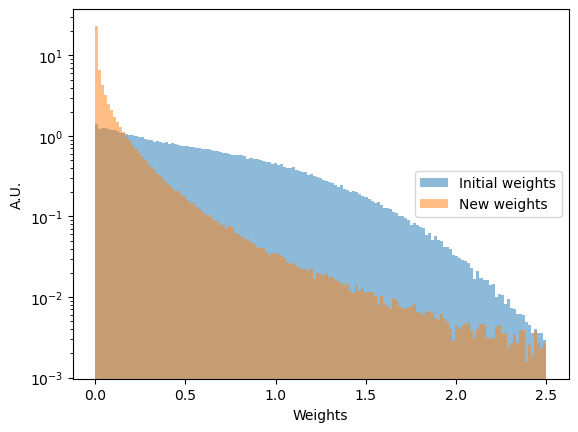

In [23]:
bins = np.linspace(0, 2.5, 150)
plt.hist(mc_weights, bins=bins, alpha=0.5, label='Initial weights', density=True)
# plt.hist(pd_weights, bins=bins, alpha=0.5, label='Pseudodata', density=True)
plt.hist(mc_newweights, bins=bins, alpha=0.5, label='New weights', density=True)
# add_stats_box(plt.gca(), mc_weights)
plt.legend(loc='center right')
plt.yscale('log')
plt.xlabel('Weights')
plt.ylabel('A.U.')
# plt.show()
plt.savefig("weights.pdf")

In [24]:
def plot_reweighting(
        source_data, 
        target_data, 
        source_weight_start, 
        source_weight_end=None,
        target_weight=None, 
        bins=150, 
        xlabel="", 
        linear_scale=False, 
        ylim=None, 
        rlim=None,
        names=None):
    """ plot_reweighting - This function will plot the quality of the reweighting
    along a given dimension. Inputs are the original data, the starting weights, the ending weights, and 
    the target data. Optional is the bins to be used in the plot, and the x-axis label.

    Arguments:
    source_data - numpy array of original data
    target_data - numpy array of target data
    source_weight_start - numpy array of starting weights for source, required
    source_weights_end - numpy array of ending weights for source. Optional if there are none
    target_weight - numpy array of weights for target, optional
    bins - number of bins to use in the plot, if not set use mpl default w/ 150 bins
    xlabel - label to use for the x-axis
    linear_scale - if true, use linear scale for y-axis, otherwise use log scale
    ylim - if set, use this as the y-axis limits
    rlim - if set, use this as the ratio axis limits
    names - an optional tuple of strings which sets the legends names for source and target data

    Returns:
    fig - matplotlib figure object
    """

    # Parse names
    if names is not None:
        name1, name2 = names
    else:
        name1 = 'MC'
        name2 = 'PseudoData'

    fig = plt.figure()
    ax, axr = add_ratios(fig)
    n_mc, bins, patches =  ax.hist(source_data, bins=bins, label=name1, density=True, alpha=0.5, weights=source_weight_start)
    if source_weight_end is not None:
        n_rw, bins, patches = ax.hist(source_data, bins=bins, label='Reweighted', density=True, histtype='step', color='black', weights=source_weight_end)
    if target_weight is None:
        target_weight = np.ones_like(target_data)
    n_pd, bins, patches = ax.hist(target_data, bins=bins, label=name2, density=True, alpha=0.5, weights=target_weight)
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_xticks([])
    ax.set_ylabel('A.U.')
    if linear_scale:
        ax.set_yscale('linear')
    else:
        ax.set_yscale('log')
    ax.legend()

    axr.hlines(1, bins[0], bins[-1], color='k', linestyle='--', alpha=0.8)
    axr.plot(bins[:-1], n_mc / n_pd, color='#1f77b4', drawstyle='steps-post')
    if source_weight_end is not None:
        axr.plot(bins[:-1], n_rw / n_pd, color='k', drawstyle='steps-post')
    axr.set_ylabel(f'{name1}/{name2}')
    axr.set_xlim(ax.get_xlim())
    axr.set_xlabel(xlabel)
    if rlim is not None:
        axr.set_ylim(rlim)

    return fig

In [25]:
def add_ratios(fig):
    """ add_ratios - This function adds ratio pads to a given matplotlib figure.

    Arguments:
    fig - matplotlib axis to add ratio pads to

    Returns:
    ax - main matplotlib axis
    axr - ratio matplotlib axis
    """

    this_grid = gs.GridSpec(2, 1, figure=fig, height_ratios=(7, 2), hspace=0.0)

    axr = fig.add_subplot(this_grid[1,0])
    ax = fig.add_subplot(this_grid[0,0])

    return ax, axr

/tmp/ipykernel_961447/1748718120.py:60: RuntimeWarning: divide by zero encountered in divide
  axr.plot(bins[:-1], n_mc / n_pd, color='#1f77b4', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:60: RuntimeWarning: invalid value encountered in divide
  axr.plot(bins[:-1], n_mc / n_pd, color='#1f77b4', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:62: RuntimeWarning: divide by zero encountered in divide
  axr.plot(bins[:-1], n_rw / n_pd, color='k', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:62: RuntimeWarning: invalid value encountered in divide
  axr.plot(bins[:-1], n_rw / n_pd, color='k', drawstyle='steps-post')


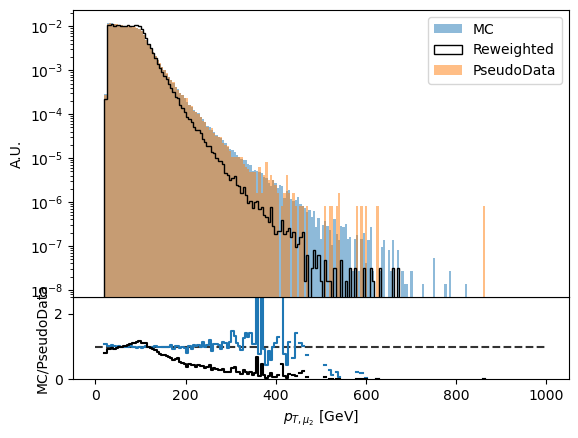

In [26]:
fig = plot_reweighting(np.array(mc_pt_l2), np.array(pd_pt_l2), mc_weights, mc_newweights, bins=np.linspace(0, 1e3, 200), xlabel=r'$p_{T, \mu_2}$ [GeV]', rlim=[0, 2.5])

/tmp/ipykernel_961447/1748718120.py:60: RuntimeWarning: divide by zero encountered in divide
  axr.plot(bins[:-1], n_mc / n_pd, color='#1f77b4', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:60: RuntimeWarning: invalid value encountered in divide
  axr.plot(bins[:-1], n_mc / n_pd, color='#1f77b4', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:62: RuntimeWarning: divide by zero encountered in divide
  axr.plot(bins[:-1], n_rw / n_pd, color='k', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:62: RuntimeWarning: invalid value encountered in divide
  axr.plot(bins[:-1], n_rw / n_pd, color='k', drawstyle='steps-post')


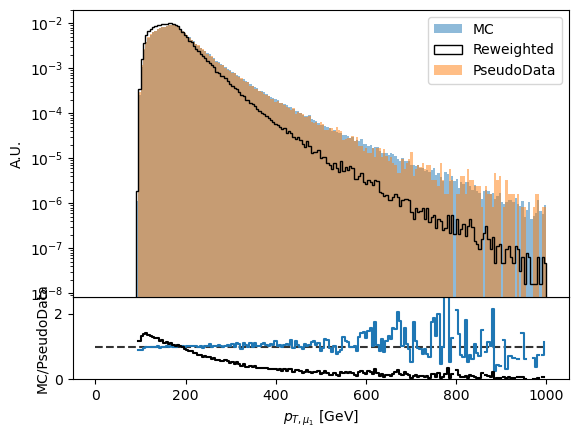

In [27]:
fig = plot_reweighting(np.array(mc_pt_l1), np.array(pd_pt_l1), mc_weights, mc_newweights, bins=np.linspace(0, 1e3, 200), xlabel=r'$p_{T, \mu_1}$ [GeV]', rlim=[0, 2.5])

/tmp/ipykernel_961447/1748718120.py:60: RuntimeWarning: divide by zero encountered in divide
  axr.plot(bins[:-1], n_mc / n_pd, color='#1f77b4', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:62: RuntimeWarning: divide by zero encountered in divide
  axr.plot(bins[:-1], n_rw / n_pd, color='k', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:62: RuntimeWarning: invalid value encountered in divide
  axr.plot(bins[:-1], n_rw / n_pd, color='k', drawstyle='steps-post')


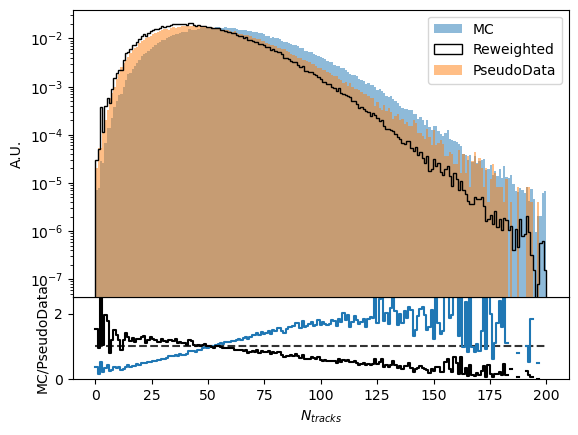

In [28]:
fig = plot_reweighting(np.array(mc_ntracks), np.array(pd_ntracks), mc_weights, mc_newweights, bins=np.linspace(0,200, 200), xlabel=r'$N_{tracks}$', rlim=[0, 2.5])

/tmp/ipykernel_961447/1748718120.py:60: RuntimeWarning: divide by zero encountered in divide
  axr.plot(bins[:-1], n_mc / n_pd, color='#1f77b4', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:60: RuntimeWarning: invalid value encountered in divide
  axr.plot(bins[:-1], n_mc / n_pd, color='#1f77b4', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:62: RuntimeWarning: divide by zero encountered in divide
  axr.plot(bins[:-1], n_rw / n_pd, color='k', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:62: RuntimeWarning: invalid value encountered in divide
  axr.plot(bins[:-1], n_rw / n_pd, color='k', drawstyle='steps-post')


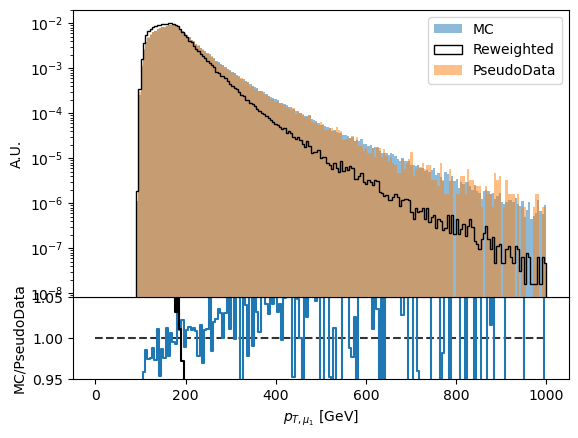

In [29]:
fig = plot_reweighting(np.array(mc_pt_l1), np.array(pd_pt_l1), mc_weights, mc_newweights, bins=np.linspace(0, 1e3, 200), xlabel=r'$p_{T, \mu_1}$ [GeV]', rlim=[0.95, 1.05])


/tmp/ipykernel_961447/1748718120.py:60: RuntimeWarning: invalid value encountered in divide
  axr.plot(bins[:-1], n_mc / n_pd, color='#1f77b4', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:62: RuntimeWarning: invalid value encountered in divide
  axr.plot(bins[:-1], n_rw / n_pd, color='k', drawstyle='steps-post')


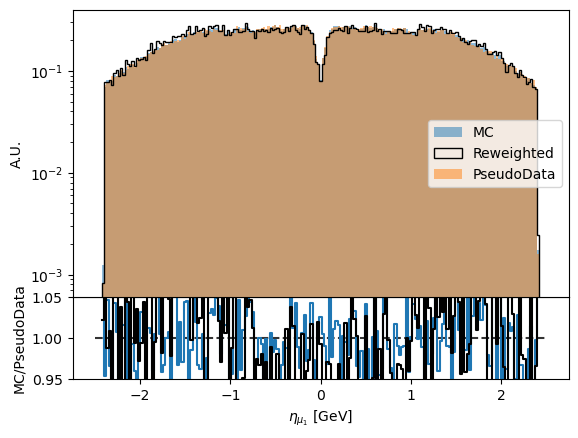

In [30]:
fig = plot_reweighting(np.array(mc_eta_l1), np.array(pd_eta_l1), mc_weights, mc_newweights, bins=np.linspace(-2.5, 2.5, 200), xlabel=r'$\eta_{\mu_1}$ [GeV]', rlim=[0.95, 1.05])


/tmp/ipykernel_961447/1748718120.py:60: RuntimeWarning: invalid value encountered in divide
  axr.plot(bins[:-1], n_mc / n_pd, color='#1f77b4', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:62: RuntimeWarning: invalid value encountered in divide
  axr.plot(bins[:-1], n_rw / n_pd, color='k', drawstyle='steps-post')


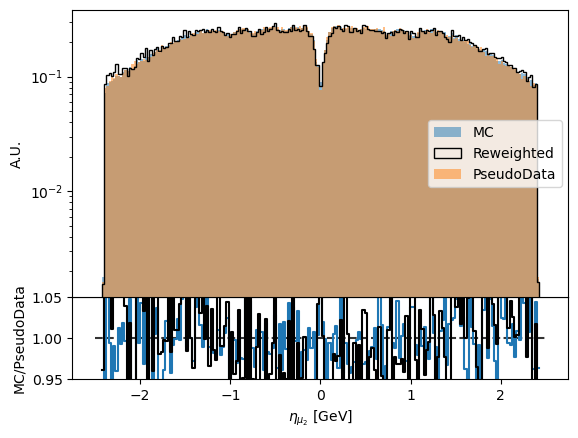

In [31]:
fig = plot_reweighting(np.array(mc_eta_l2), np.array(pd_eta_l2), mc_weights, mc_newweights, bins=np.linspace(-2.5, 2.5, 200), xlabel=r'$\eta_{\mu_2}$ [GeV]', rlim=[0.95, 1.05])


In [32]:
mc_alltrack_pt = tree_mc['pT_tracks'].array()
pd_alltrack_pt = tree_pd['pT_tracks'].array()


In [33]:
mc_alltrack_pt_p190 = mc_alltrack_pt[pass190_mc == 1]
pd_alltrack_pt_p190 = pd_alltrack_pt[pass190_pd == 1]



In [34]:
mc_ht = ak.sum(mc_alltrack_pt_p190, axis=1)
pd_ht = ak.sum(pd_alltrack_pt_p190, axis=1)


In [35]:
mc_htnp = ak.to_numpy(mc_ht)
pd_htnp = ak.to_numpy(pd_ht)


/tmp/ipykernel_961447/1748718120.py:60: RuntimeWarning: divide by zero encountered in divide
  axr.plot(bins[:-1], n_mc / n_pd, color='#1f77b4', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:60: RuntimeWarning: invalid value encountered in divide
  axr.plot(bins[:-1], n_mc / n_pd, color='#1f77b4', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:62: RuntimeWarning: divide by zero encountered in divide
  axr.plot(bins[:-1], n_rw / n_pd, color='k', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:62: RuntimeWarning: invalid value encountered in divide
  axr.plot(bins[:-1], n_rw / n_pd, color='k', drawstyle='steps-post')


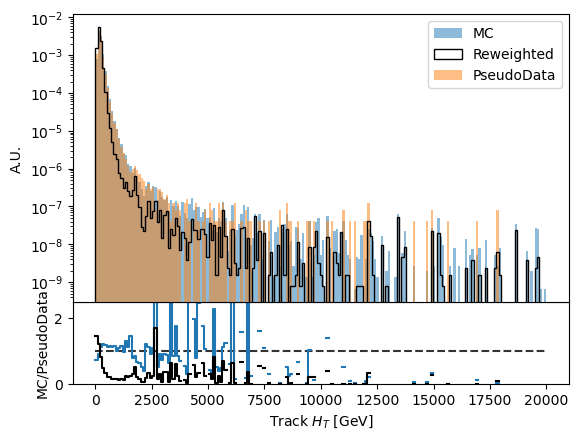

In [36]:
fig = plot_reweighting(np.array(mc_htnp), np.array(pd_htnp), mc_weights, mc_newweights, bins=np.linspace(0,20000, 200), xlabel=r'Track $H_{T}$ [GeV]', rlim=[0, 2.5])


In [37]:
mc_px_l1 = mc_pt_l1 * np.cos(mc_phi_l1)
pd_px_l1 = pd_pt_l1 * np.cos(pd_phi_l1)


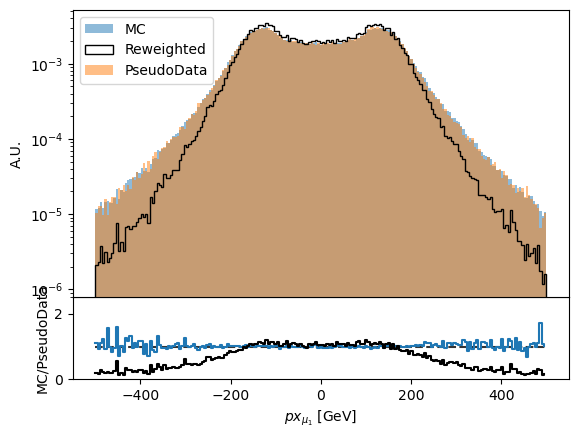

In [38]:
fig = plot_reweighting(np.array(mc_px_l1), np.array(pd_px_l1), mc_weights, mc_newweights, bins=np.linspace(-500,500, 200), xlabel=r'$px_{\mu_1}$ [GeV]', rlim=[0, 2.5])


In [39]:
mc_px_l2 = mc_pt_l2 * np.cos(mc_phi_l2)
pd_px_l2 = pd_pt_l2 * np.cos(pd_phi_l2)

/tmp/ipykernel_961447/1748718120.py:60: RuntimeWarning: divide by zero encountered in divide
  axr.plot(bins[:-1], n_mc / n_pd, color='#1f77b4', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:60: RuntimeWarning: invalid value encountered in divide
  axr.plot(bins[:-1], n_mc / n_pd, color='#1f77b4', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:62: RuntimeWarning: divide by zero encountered in divide
  axr.plot(bins[:-1], n_rw / n_pd, color='k', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:62: RuntimeWarning: invalid value encountered in divide
  axr.plot(bins[:-1], n_rw / n_pd, color='k', drawstyle='steps-post')


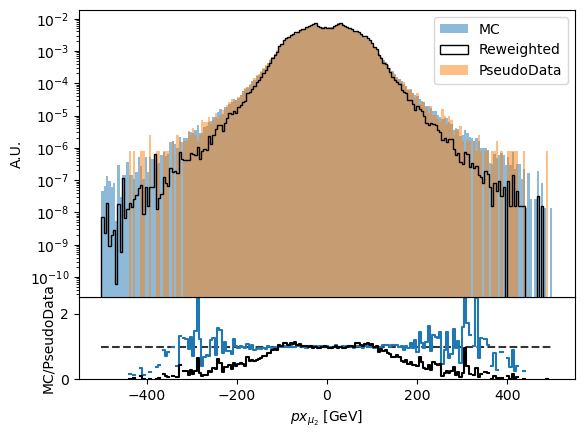

In [40]:
fig = plot_reweighting(np.array(mc_px_l2), np.array(pd_px_l2), mc_weights, mc_newweights, bins=np.linspace(-500,500, 200), xlabel=r'$px_{\mu_2}$ [GeV]', rlim=[0, 2.5])


In [41]:
mc_py_l1 = mc_pt_l1 * np.sin(mc_phi_l1)
pd_py_l1 = pd_pt_l1 * np.sin(pd_phi_l1)
mc_py_l2 = mc_pt_l2 * np.sin(mc_phi_l2)
pd_py_l2 = pd_pt_l2 * np.sin(pd_phi_l2)


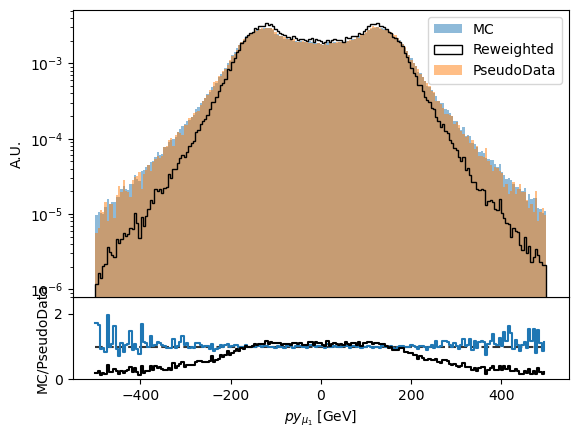

In [42]:
fig = plot_reweighting(np.array(mc_py_l1), np.array(pd_py_l1), mc_weights, mc_newweights, bins=np.linspace(-500,500, 200), xlabel=r'$py_{\mu_1}$ [GeV]', rlim=[0, 2.5])


/tmp/ipykernel_961447/1748718120.py:60: RuntimeWarning: divide by zero encountered in divide
  axr.plot(bins[:-1], n_mc / n_pd, color='#1f77b4', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:60: RuntimeWarning: invalid value encountered in divide
  axr.plot(bins[:-1], n_mc / n_pd, color='#1f77b4', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:62: RuntimeWarning: divide by zero encountered in divide
  axr.plot(bins[:-1], n_rw / n_pd, color='k', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:62: RuntimeWarning: invalid value encountered in divide
  axr.plot(bins[:-1], n_rw / n_pd, color='k', drawstyle='steps-post')


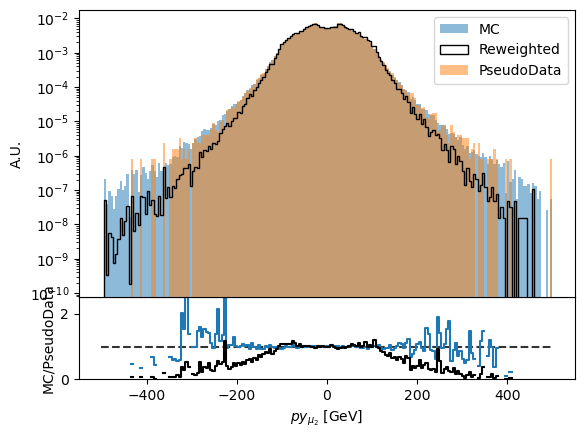

In [43]:
fig = plot_reweighting(np.array(mc_py_l2), np.array(pd_py_l2), mc_weights, mc_newweights, bins=np.linspace(-500,500, 200), xlabel=r'$py_{\mu_2}$ [GeV]', rlim=[0, 2.5])


In [46]:
mass=0.

In [49]:
mc_e_l1 = np.sqrt(mc_pt_l1**2 * np.cosh(mc_eta_l1)**2 + mass**2)
mc_e_l2 = np.sqrt(mc_pt_l2**2 * np.cosh(mc_eta_l2)**2 + mass**2)

pd_e_l1 = np.sqrt(pd_pt_l1**2 * np.cosh(pd_eta_l1)**2 + mass**2)
pd_e_l2 = np.sqrt(pd_pt_l2**2 * np.cosh(pd_eta_l2)**2 + mass**2)

/tmp/ipykernel_961447/1748718120.py:60: RuntimeWarning: divide by zero encountered in divide
  axr.plot(bins[:-1], n_mc / n_pd, color='#1f77b4', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:60: RuntimeWarning: invalid value encountered in divide
  axr.plot(bins[:-1], n_mc / n_pd, color='#1f77b4', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:62: RuntimeWarning: divide by zero encountered in divide
  axr.plot(bins[:-1], n_rw / n_pd, color='k', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:62: RuntimeWarning: invalid value encountered in divide
  axr.plot(bins[:-1], n_rw / n_pd, color='k', drawstyle='steps-post')


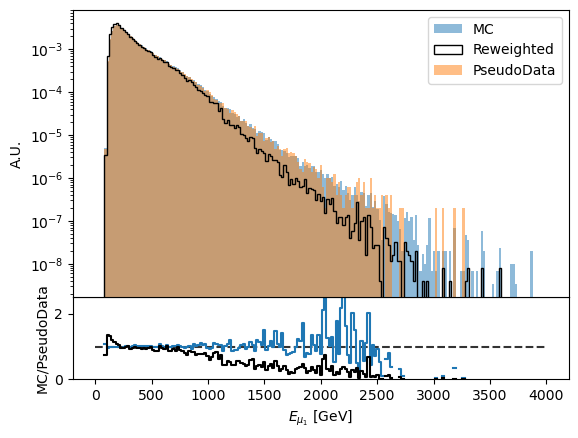

In [52]:
fig = plot_reweighting(np.array(mc_e_l1), np.array(pd_e_l1), mc_weights, mc_newweights, bins=np.linspace(0,4000, 200), xlabel=r'$E_{\mu_1}$ [GeV]', rlim=[0, 2.5])


/tmp/ipykernel_961447/1748718120.py:60: RuntimeWarning: divide by zero encountered in divide
  axr.plot(bins[:-1], n_mc / n_pd, color='#1f77b4', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:60: RuntimeWarning: invalid value encountered in divide
  axr.plot(bins[:-1], n_mc / n_pd, color='#1f77b4', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:62: RuntimeWarning: divide by zero encountered in divide
  axr.plot(bins[:-1], n_rw / n_pd, color='k', drawstyle='steps-post')
/tmp/ipykernel_961447/1748718120.py:62: RuntimeWarning: invalid value encountered in divide
  axr.plot(bins[:-1], n_rw / n_pd, color='k', drawstyle='steps-post')


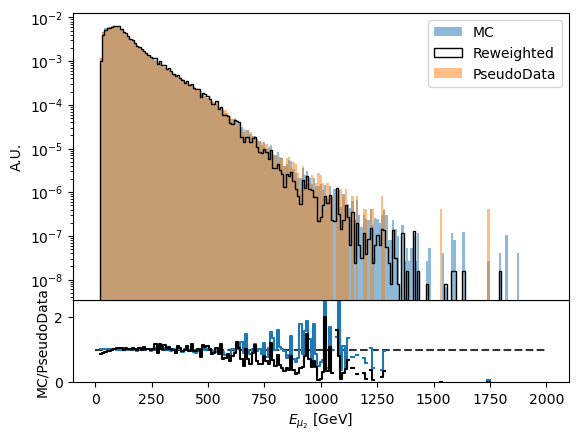

In [54]:
fig = plot_reweighting(np.array(mc_e_l2), np.array(pd_e_l2), mc_weights, mc_newweights, bins=np.linspace(0,2000, 200), xlabel=r'$E_{\mu_2}$ [GeV]', rlim=[0, 2.5])
